In [13]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0


In [14]:
!nvidia-smi

Tue Mar  4 18:27:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:02:00.0  On |                  N/A |
| 53%   45C    P3             25W /  170W |     809MiB /  12288MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
import numpy as np
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
import cv2
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras


In [16]:
train_data = "/home/aman/Projects/traffic-recognition/ml/data/external/train"

In [17]:
def convert_to_greyscale(image):
    """
    Formula used: G = 0.2989 * R + 0.5870 * G + 0.1140 * B
    """

    if image.shape[-1] == 3:  # Check if it's a color image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    R, G, B = image[:,:,0], image[:,:,1], image[:,:,2]
    grey_image = 0.2989 * R + 0.5870 * G + 0.1140 * B
    grey_image = np.uint8(grey_image)

    return grey_image

def binary_threshold_no_cv(image, threshold_value=127):
    """
    Convert an image to binary using manual thresholding.
    
    :param image: The input image (grayscale).
    :param threshold_value: The threshold value to classify pixels as either black or white.
    :return: Binary thresholded image.
    """
    if isinstance(image, Image.Image):
        image = np.array(image)

    binary_image = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(image.shape[0]):  # iterate over rows
        for j in range(image.shape[1]):  # iterate over columns
            if image[i, j] > threshold_value:
                binary_image[i, j] = 255  # Set pixel to white
            else:
                binary_image[i, j] = 0    # Set pixel to black

    return binary_image

In [18]:
def loadDataSet(dataPath):
    data = []
    imageSize = 28
    for cat in os.listdir(dataPath):
        label = int(cat[:2])
        for i in os.listdir(dataPath+'/'+cat):
            imagePath = dataPath+'/'+cat+'/'+i
            try:
                image = cv2.imread(imagePath,0) 
                image = cv2.resize(image,(imageSize,imageSize))
                data.append([image,label])
            except:
                pass
    
    random.shuffle(data)
    
    X = [] #image
    Y = [] #labels
    for img,l in data: 
        X.append(img)
        Y.append(l)
    X = np.array(X)
    Y = np.array(Y).reshape(len(Y),1)
    return X,Y

In [19]:
images, labels = loadDataSet(train_data)

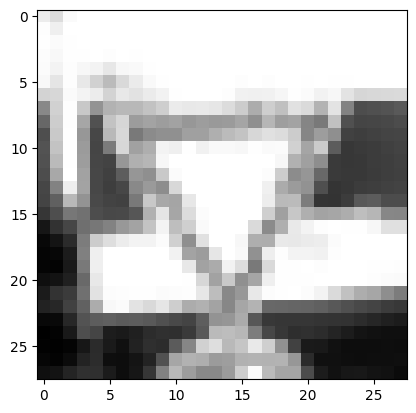

[3]


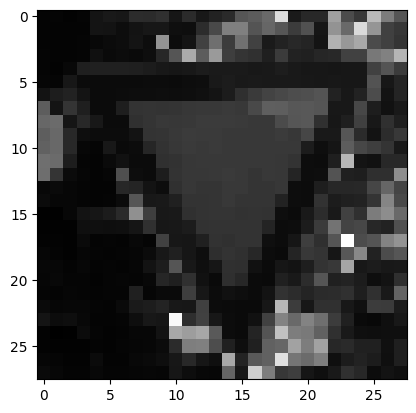

[3]


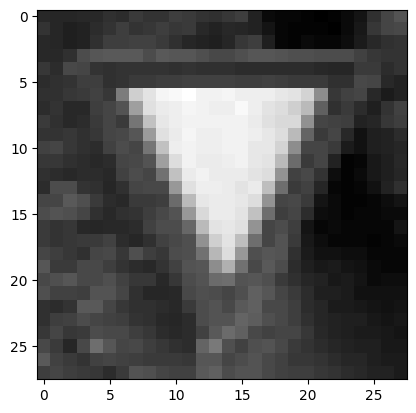

[3]


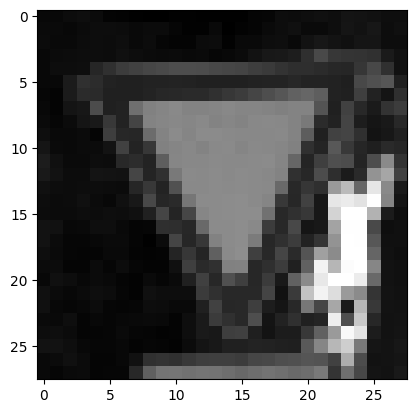

[3]


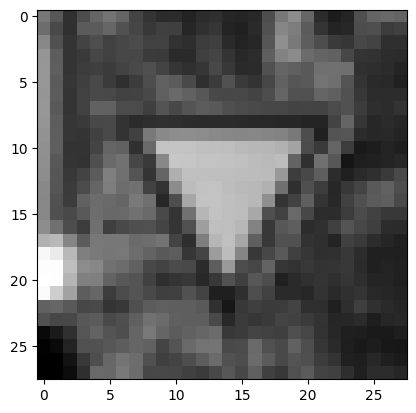

[3]


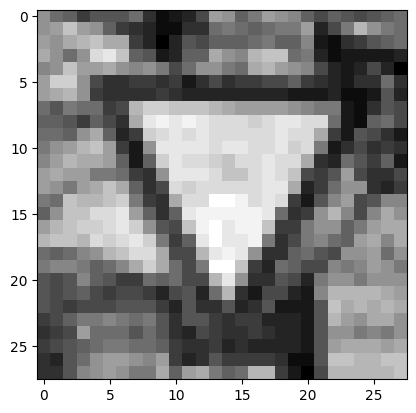

[3]


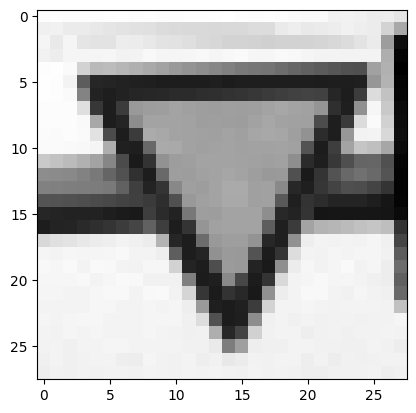

[3]


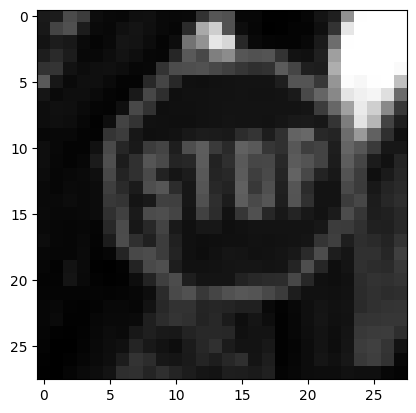

[0]


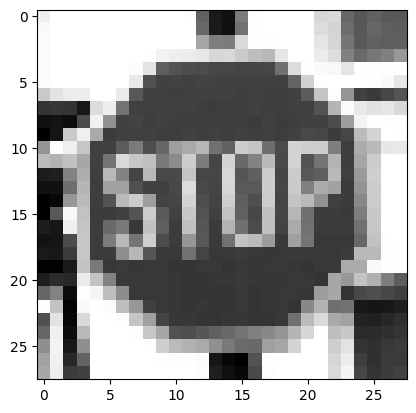

[0]


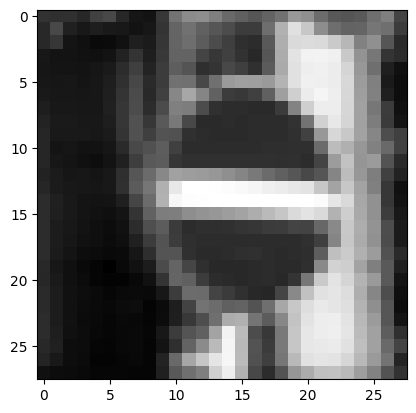

[1]


In [20]:
for i in range(10):
    plt.imshow(images[i],cmap='gray')
    plt.show()
    print(labels[i])

In [21]:
mu = np.mean(images)
std = np.std(images)
print("The Mean = ",mu)
print("The Standard Deviation = ",std)

The Mean =  92.39488493223836
The Standard Deviation =  70.77168647587727


In [22]:
images.shape

(4739, 28, 28)

In [23]:
m = images.shape[0]
imageShape = images.shape[1:]

In [24]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(images,labels,test_size=0.2,random_state=0)
print("Count of Training Example = ",x_train.shape[0])
print("Count of Validation Example = ",x_test.shape[0])

Count of Training Example =  3791
Count of Validation Example =  948


In [25]:
x_train_Norm = (x_train - mu) / std
x_test_Norm  = (x_test - mu) / std
x_train_Norm = x_train_Norm.reshape(3791, 28, 28,1)
x_test_Norm = x_test_Norm.reshape(948, 28, 28,1)

In [26]:
def preprocessingImage(image=None,imageSize=28,mu=89.77428691773054,std=70.85156431910688):
    try:
        image = convert_to_greyscale(image)
    except:
        pass
    image = cv2.resize(image,(imageSize,imageSize))
    image = (image - mu) / std
    image = image.reshape(1,imageSize,imageSize,1)
    return image

In [27]:
class myCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.997):
            self.model.stop_training=True

In [28]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=8,kernel_size=(3,3),activation='relu',input_shape=(28,28,1)),
    keras.layers.MaxPool2D(pool_size=(4,4)),
    keras.layers.Flatten(),
    keras.layers.Dense(4,tf.nn.softmax)
])


model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

/home/aman/Projects/traffic-recognition/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1741142168.740203  218608 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9541 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:02:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,236 (4.83 KB)

 Trainable params: 1,236 (4.83 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
#Fitting 
model.fit(x_train_Norm,
          y_train,
          epochs = 15,
          callbacks = [myCallBack()])

Epoch 1/15


I0000 00:00:1741142190.831141  277488 service.cc:148] XLA service 0x7b8848001800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741142190.831164  277488 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-04 18:36:30.850621: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741142190.936729  277488 cuda_dnn.cc:529] Loaded cuDNN version 90300


 43/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4488 - loss: 1.2449

I0000 00:00:1741142193.098560  277488 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5531 - loss: 1.0939
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8827 - loss: 0.4771
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9607 - loss: 0.2537
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9679 - loss: 0.1691
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9846 - loss: 0.1244
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9877 - loss: 0.0911
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9893 - loss: 0.0804
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9905 - loss: 0.0714
Epoch 9/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9918 - loss: 0.0540
Epoch 10/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0481
Epoch 11/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9957 - loss: 0.0463
Epoch 12/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accurac

In [31]:
model.evaluate(x_test_Norm,
               y_test,
               verbose = 0)

[0.03709014877676964, 0.9915611743927002]

In [34]:
model.save('/home/aman/Projects/traffic-recognition/ml/src/models/TSModel.keras')

In [37]:
model=keras.models.load_model('/home/aman/Projects/traffic-recognition/ml/src/models/TSModel.keras')

TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135831646781616}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 28, 28, 1], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 8, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 1]}}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135831646781616}, 'pool_size': [4, 4], 'padding': 'valid', 'strides': [4, 4], 'data_format': 'channels_last'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135831646781616}, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 8]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135831646781616}, 'units': 4, 'activation': {'module': 'builtins', 'class_name': 'function', 'config': 'softmax_v2', 'registered_name': 'function'}, 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 288]}}], 'build_input_shape': [None, 28, 28, 1]}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 1]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'sparse_categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: <class 'keras.src.layers.core.dense.Dense'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135831646781616}, 'units': 4, 'activation': {'module': 'builtins', 'class_name': 'function', 'config': 'softmax_v2', 'registered_name': 'function'}, 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 288]}}.

Exception encountered: Error when deserializing class 'Dense' using config={'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 4, 'activation': {'module': 'builtins', 'class_name': 'function', 'config': 'softmax_v2', 'registered_name': 'function'}, 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}.

Exception encountered: Could not interpret activation function identifier: {'module': 'builtins', 'class_name': 'function', 'config': 'softmax_v2', 'registered_name': 'function'}

In [36]:
!pip3 install --upgrade tensorflow keras